In [ ]:
!pip install nb-black

In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import sys

sys.path.insert(0, "../")

## Dataset

In [3]:
import os
from typing import Dict, List, Tuple, Any, Union, Callable
from torch import Tensor
import torch
import numpy as np
import scipy
from torch.utils.data import DataLoader
from pytorch_lightning.utilities.apply_func import apply_to_collection
from cspnn.data.bci.bci_dataset import BCI2aDataset
from cspnn.data.utils import eeg_electrode_configs

from tqdm.notebook import tqdm

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [4]:
class ToTensor:
    def __init__(self, device):
        if isinstance(device, str):
            device = torch.device(device)
        self.device = device

    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.from_numpy(a),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.tensor(a, dtype=torch.float64),
        )

        return data, label


class ToNumpy:
    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )

        return data, label


class DictToTensor:
    def __call__(self, data: Dict[str, Tensor], label):
        # The output shape [batch, channel, signal]
        return (
            torch.permute(
                torch.vstack(list(map(lambda a: a.unsqueeze(0), data.values()))),
                (1, 0, 2),
            ),
            label,
        )


class DictToArray:
    def __call__(self, data, label):
        # The output shape [batch, channel, signal]
        return (
            np.transpose(
                np.vstack(
                    list(map(lambda a: np.expand_dims(a, axis=0), data.values()))
                ),
                (1, 0, 2),
            ),
            label,
        )


class Windowing:
    def __init__(self, n_segments: int = 5, sample_rate: float = 250.0):
        self.n_segments = n_segments
        self.sample_rate = sample_rate

    # The Output of the signal is [batch, channels, windowed, band_filtered, signal]
    def __call__(self, data: Tensor, label):
        """Takes as input a signal tensor of shape [batch, channels, band_filtered, signal]
        and outputs a signal tensor of shape [batch, channels, windowed, band_filtered, signal]
        """
        start, end = 0, data.size()[-1]
        step = int((end - start) / self.n_segments)
        windows = np.arange(start, end - step, step=step)

        if len(windows) == 0:
            data = data.unsqueeze(dim=2)
            return data, label

        windowed_data = torch.permute(
            torch.stack(
                [data[:, :, :, window : (window + step)] for window in windows], dim=0
            ),
            (1, 2, 0, 3, 4),
        )

        return windowed_data, label


class Filtering:
    def __init__(self, N: int, rs: float, Wns: List[float], bandwidth, fs: float):
        self.N = N
        self.rs = rs
        self.Wns = Wns / (fs / 2)  # Normalize the signals
        self.bandwidth = bandwidth / (fs / 2)  # Normalize the signals
        self.fs = fs

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = []

        for wn in self.Wns:
            b, a = scipy.signal.cheby2(
                N=self.N,
                rs=self.rs,
                Wn=[wn, wn + self.bandwidth],
                btype="bandpass",
                fs=self.fs,
            )
            filtered_data.append(scipy.signal.filtfilt(b, a, data, axis=-1))

        filtered_data = torch.permute(torch.Tensor(filtered_data), (1, 2, 0, 3))

        return filtered_data, label


class ExpandDim(object):
    def __init__(self, dim):
        self.dim = dim

    def __call__(self, data, label):
        return data.unsqueeze_(self.dim), label


class LabelToDict:
    def __call__(self, data, label):
        return data, {"label": label}


class ToNumpy:
    def __call__(self, data, label):
        return data.cpu().detach().numpy(), label.cpu().detach().numpy()


class Compose:
    def __init__(self, transforms: List[Callable]) -> None:
        self.transforms = transforms

    def __call__(self, data: Any, target: Any):
        for t in self.transforms:
            data, target = t(data, target)
        return data, target

    def __repr__(self):
        return "\n".join([c.__class__.__name__ for c in self.transforms])


# TODO: complete this part
from scipy.signal import cheby2, filtfilt


def cheby_bandpass_filter(signal, attenuation, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = cheby2(order, rs=attenuation, Wn=[low, high], btype="band")
    y = filtfilt(b, a, signal, axis=-1)
    # print("filtered shape ", y.shape)
    return y


def cheby_bandpass_one_subject(
    X, attenuation, lowcut, highcut, fs, interval=None, verbose=True
):
    temp_epoch_EEG = X.copy()
    # print(f"data shape : {temp_epoch_EEG.shape}")

    if interval is not None:
        startband = np.arange(lowcut, highcut, step=interval)

        bands = []
        for start in startband:
            # This will be new key inside the EEG_filtered
            band = "{:02d}_{:02d}".format(start, start + interval)

            if verbose:
                print("Filtering through {} Hz band".format(band))
            # Bandpass filtering
            bands.append(
                cheby_bandpass_filter(
                    temp_epoch_EEG, attenuation, start, start + interval, fs
                )
            )

        return np.vstack(bands)

    else:
        # This will be new key inside the EEG_filtered
        band = "{:02d}_{:02d}".format(lowcut, highcut)

        return cheby_bandpass_filter(temp_epoch_EEG, attenuation, lowcut, highcut, fs)


from functools import partial


class BandPass:
    def __init__(self, attenuation, lowcut, highcut, fs, interval=None):
        self.attenuation = attenuation
        self.lowcut = lowcut
        self.highcut = highcut
        self.fs = fs
        self.interval = interval

        self.bandpass_func = partial(
            cheby_bandpass_one_subject,
            attenuation=self.attenuation,
            lowcut=self.lowcut,
            highcut=self.highcut,
            fs=self.fs,
            interval=self.interval,
            verbose=False,
        )

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64, Tensor),
            function=self.bandpass_func,
        )

        filtered_data = np.expand_dims(filtered_data.transpose(1, 0, 2), axis=0)

        return filtered_data, label

In [6]:
directory = "../test_data"
electrod_positions, shape = eeg_electrode_configs(
    "../configs/eeg_recording_standard/international_10_20_22.py"
)
if not os.path.exists(directory):
    os.makedirs(directory)


fs = 250
low_freq = 4
high_freq = 38
bandwidth = 4
overlap = 2

freqs = np.arange(low_freq, high_freq - (bandwidth - overlap), overlap)

lowcut = 4
highcut = 40
fs = 250
attenuation = 40
interval = 4

transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    # ToNumpy(),
    # BandPass(
    #     attenuation=attenuation,
    #     lowcut=lowcut,
    #     highcut=highcut,
    #     fs=fs,
    #     interval=interval,
    # ),
    # ToTensor(device="cpu"),
    # Filtering(N=4, rs=40, Wns=freqs, bandwidth=bandwidth, fs=fs),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    # Windowing(n_segments=1),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
)

In [7]:
for i in range(len(ds)):
    wave, label = ds[i]
    print(wave.min(), wave.max())
    print(wave.shape)
    if np.isnan(wave).any() or np.isinf(wave).any():
        print(f"date {i} : has NAN or INF")
    break

tensor(-22.1658, dtype=torch.float64) tensor(18.0601, dtype=torch.float64)
torch.Size([1, 22, 1, 1, 1001])


In [8]:
def collate_fn(batch):
    imgs = torch.vstack([item[0] for item in batch])

    trgts = {}
    sample_item_label = batch[0][1]
    for label_key in sample_item_label.keys():
        if isinstance(sample_item_label[label_key], dict):
            trgts[label_key] = {
                key: torch.vstack([item[1][label_key][key].squeeze() for item in batch])
                for key in sample_item_label[label_key].keys()
            }
        else:
            trgts[label_key] = torch.vstack(
                [item[1][label_key] for item in batch]
            ).squeeze()

    return [imgs, trgts]

In [9]:
batch_size = 32
train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)

## Investigating Whitening Methods

In [ ]:
csp_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
)

In [ ]:
signal = []
label = []
for sig, lbl in tqdm(csp_dataloader):
    signal.append(sig)
    label.append(lbl["label"])
signal = torch.vstack(signal)
label = torch.stack(label)

In [ ]:
signal.size(), label.size()

In [ ]:
import matplotlib.pyplot as plt
import scipy.linalg as la

In [ ]:
def calc_cov(EEG_data):
    """
    INPUT:
    EEG_data : EEG_data in shape T x N x S

    OUTPUT:
    avg_cov : covariance matrix of averaged over all trials
    """
    cov = []
    for i in range(EEG_data.size()[0]):
        cov.append(
            EEG_data[i] @ EEG_data[i].T / torch.trace(EEG_data[i] @ EEG_data[i].T)
        )

    cov = torch.mean(torch.stack(cov), 0)

    return cov

In [ ]:
x = signal.squeeze()
sig = x.permute(0, 2, 1)
x = torch.mean(sig, axis=1)
x_mean = torch.mean(x, axis=0)
sig.size(), x_mean.size()

In [ ]:
x = sig - x_mean
x_zero_centered = x.permute(0, 2, 1)
x_zero_centered.size()

In [ ]:
x = x_zero_centered
x_cov = calc_cov(x)
x_cov.shape

In [ ]:
plt.imshow(x_cov, cmap="hot", interpolation="nearest")
plt.show()

In [ ]:
lda, V = torch.linalg.eig(x_cov)
lda, V = lda.real, V.real
whitening_mat = V @ torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T
# print(torch.allclose(whitening_mat, torch.sqrt(torch.inverse(x_cov))))
# whitening_mat = torch.inverse(torch.sqrt(x_cov))

whitening_mat.size()

In [ ]:
plt.imshow(whitening_mat, cmap="hot", interpolation="nearest")
plt.show()

In [ ]:
whitened_signal = whitening_mat @ x_zero_centered
whitened_signal.size()

In [ ]:
x = whitened_signal
whitened_signal_cov = calc_cov(x)
whitened_signal_cov.shape

In [ ]:
plt.imshow(whitened_signal_cov, cmap="hot", interpolation="nearest")
plt.show()

## Pytorch Dataset Transform Model

In [18]:
import matplotlib.pyplot as plt

def calc_cov(EEG_data):
    """
    INPUT:
    EEG_data : EEG_data in shape T x N x S

    OUTPUT:
    avg_cov : covariance matrix of averaged over all trials
    """
    cov = []
    for i in range(EEG_data.size()[0]):
        cov.append(
            EEG_data[i] @ EEG_data[i].T / torch.trace(EEG_data[i] @ EEG_data[i].T)
        )

    cov = torch.mean(torch.stack(cov), 0)

    return cov


class Whitening:
    def __init__(self, data_loader, whitening_method="PCA"):
        self.ds = data_loader
        self.method = whitening_method

        self.W = self._generate_whitening_transformation(self.ds, self.method)

    def _generate_whitening_transformation(self, data_loader, whitening_method="PCA"):
        """extract whitening transformation from data

        Parameters
        ----------
        data_loader : torch.dataloader
            pytorch data loader
        whitening_method : str
            one of following values
            "PCA" for PCA whitening
            "ZCA for ZCA whitening

        Returns
        -------
        torch.Tensor
            whitening transformation matrix
        """
        # get data
        signal = []
        for sig, lbl in data_loader:
            signal.append(sig)
        signal = torch.vstack(signal)

        # zero center
        x = signal.squeeze()
        sig = x.permute(0, 2, 1)
        x = torch.mean(sig, axis=1)
        x_mean = torch.mean(x, axis=0)

        x = sig - x_mean
        x_zero_centered = x.permute(0, 2, 1)

        # Calculate whitening matrix
        x_cov = self._calc_cov(x_zero_centered)

        lda, V = torch.linalg.eig(x_cov)
        lda, V = lda.real, V.real
        if "PCA":
            whitening_mat = torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T
        elif "ZCA":
            whitening_mat = V @ torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T

        return whitening_mat

    def _calc_cov(self, EEG_data):
        cov = []
        for i in range(EEG_data.size()[0]):
            cov.append(
                EEG_data[i] @ EEG_data[i].T / torch.trace(EEG_data[i] @ EEG_data[i].T)
            )

        cov = torch.mean(torch.stack(cov), 0)

        return cov

    def __call__(self, data: Tensor, label):
        whitened_data = self.W @ data
        return whitened_data, label

In [11]:
transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
    patients=[4],
)

In [12]:
train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
)

In [13]:
transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    Whitening(train_dataloader, whitening_method="ZCA"),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds_w = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
    patients=[4],
)

In [14]:
ds_w[0][0].size()

torch.Size([1, 22, 1, 1, 1001])

In [15]:
# train_dataset, _ = ds_w.get_train_test_subsets()

# train_dataloader = DataLoader(
#     train_dataset,
#     batch_size=1,
#     shuffle=False,
#     collate_fn=collate_fn,
#     num_workers=1,
# )

batch_size = 32
train_dataset, val_dataset = ds_w.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)

In [19]:
signal = []
for sig, lbl in tqdm(train_dataloader):
    signal.append(sig)
signal = torch.vstack(signal)
signal.size()

  0%|          | 0/9 [00:00<?, ?it/s]

torch.Size([288, 22, 1, 1, 1001])

In [20]:
whitened_signal_cov = calc_cov(signal.squeeze())
whitened_signal_cov.shape

torch.Size([22, 22])

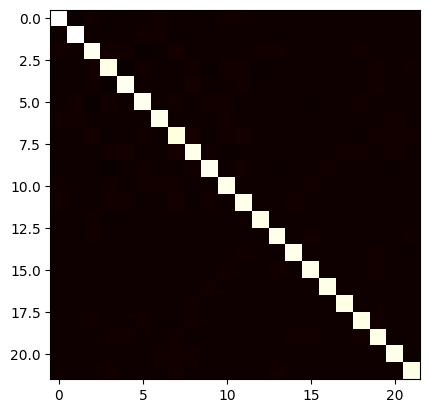

In [24]:
plt.imshow(whitened_signal_cov, cmap="hot", interpolation="nearest")
plt.show()

# Model

In [25]:
import torch
import numpy as np
import torch.nn as nn
from cspnn.csp_nn import CSP, CSPNN

import torch.optim as optim

import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    accuracy_score,
    cohen_kappa_score,
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import random

In [26]:
def evaluate(model, dl, params=["acc"]):
    model.eval()
    results = []
    predicted = []
    Y = []

    for batch in dl:
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )
        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        pred = model(inputs.float().cuda(0))

        predicted.append(pred.cpu().detach())
        Y.append(labels["label"].type(torch.LongTensor).cpu())

    predicted = torch.cat(predicted, 0)
    Y = torch.cat(Y, 0)

    loss = cls_criterion(predicted, Y)

    predicted = predicted.numpy()
    Y = Y.numpy()

    for param in params:
        if param == "acc":
            results.append(accuracy_score(Y, np.argmax(predicted, axis=1)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted, multi_class="ovr"))
        if param == "kappa":
            results.append(cohen_kappa_score(Y, np.argmax(predicted, axis=1)))
        if param == "recall":
            results.append(
                recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "precision":
            results.append(
                precision_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "fmeasure":
            precision = precision_score(
                Y, np.argmax(predicted, axis=1), average="micro"
            )
            recall = recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            results.append(2 * precision * recall / (precision + recall))

    results.append(loss)
    return results

In [27]:
class CSPNNCls(nn.Module):
    def __init__(
        self,
        num_channels: int,
        num_features: int = None,
        num_bands: int = None,
        num_windows: int = 1,
        num_labels: int = None,
        mode: str = "constant",
    ):
        super(CSPNNCls, self).__init__()
        self.num_channels = num_channels
        self.num_features = num_channels if num_features is None else num_features
        self.num_bands = num_bands
        self.num_windows = num_windows
        self.num_labels = num_labels
        self.mode = mode

        self.conv1 = CSPNN(
            num_channels=num_channels,
            num_features=num_features,
            num_bands=num_bands,
            num_windows=num_windows,
            num_labels=num_labels,
            mode=self.mode,
        )

        self.fc1 = nn.Linear(
            self.num_bands * self.num_windows * self.num_labels * self.num_features, 500
        )
        self.fc = nn.Linear(500, 4)

    def forward(self, x):
        csp = self.conv1(x)

        features = csp.reshape(
            (
                -1,
                self.num_bands * self.num_windows * self.num_labels * self.num_features,
            )
        )

        x = torch.tanh(self.fc1(features))

        x = F.softmax(self.fc(x), dim=1)
        if self.training:
            return x, csp
        return x


net = CSPNNCls(
    num_channels=22, num_features=22, num_bands=1, num_windows=1, num_labels=4
)
# .cuda(0)
cls_criterion = nn.CrossEntropyLoss()  # nn.BCELoss()
# reg_criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.00)
# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=0.1, steps_per_epoch=1, epochs=200
# )
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

In [28]:
signals = torch.empty((10, 22, 1, 16, 769), dtype=torch.float32).random_(1, 50)
a, b = net(signals)
a.size(), b.size()

(torch.Size([10, 4]), torch.Size([10, 4, 22]))

In [29]:
net = net.cuda()

In [ ]:
history = {
    "train_loss": [],
    "test_loss": [],
    "train_acc": [],
    "test_acc": [],
    "lr": [],
    "train_kappa": [],
    "test_kappa": [],
}
batch_size = 32
alpha = 0.5

for epoch in range(1000):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)

    net.train()
    running_loss = 0.0
    for i, batch in tqdm(enumerate(train_dataloader)):
        
        # print(i)
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )

        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, csp_out = net(inputs.float().cuda(0))
        cls_loss = cls_criterion(
            outputs, labels["label"].type(torch.LongTensor).cuda(0)
        )
        # reg_loss = reg_criterion(csp, labels["csp"].cuda(0))
        # loss = cls_loss + (alpha * reg_loss)
        loss = cls_loss
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    history["lr"].append(optimizer.param_groups[0]["lr"])
    # print(optimizer.param_groups[0]["lr"])
    lr_scheduler.step()

    # Validation accuracy
    params = ["acc", "kappa", "auc", "fmeasure", "loss"]
    print(params)
    print("Training Loss ", running_loss / len(train_dataloader))
    tr = evaluate(net, train_dataloader, params)
    print("Train - ", tr)
    ev = evaluate(net, val_dataloader, params)
    print("Validation - ", ev)
    history["train_loss"].append(tr[-1])
    history["train_acc"].append(tr[0])
    history["train_kappa"].append(tr[1])

    history["test_loss"].append(ev[-1])
    history["test_acc"].append(ev[0])
    history["test_kappa"].append(ev[1])


Epoch  0


9it [00:01,  7.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4107387728161283


Train -  [0.25, 0.0, 0.5681102109053499, 0.25, tensor(1.4012)]
Validation -  [0.25, 0.0, 0.6087962962962963, 0.25, tensor(1.4008)]

Epoch  1


9it [00:00, 11.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4128891626993816


Train -  [0.25, 0.0, 0.6386156121399177, 0.25, tensor(1.4068)]
Validation -  [0.25, 0.0, 0.6816968878600824, 0.25, tensor(1.4063)]

Epoch  2


9it [00:00, 12.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4154255390167236


Train -  [0.2465277777777778, -0.004629629629629539, 0.6695923353909465, 0.2465277777777778, tensor(1.4089)]
Validation -  [0.25, 0.0, 0.7028034979423868, 0.25, tensor(1.4087)]

Epoch  3


9it [00:00, 10.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4126785066392686


Train -  [0.25, 0.0, 0.6914223251028807, 0.25, tensor(1.3987)]
Validation -  [0.25, 0.0, 0.7260239840534979, 0.25, tensor(1.3984)]

Epoch  4


9it [00:00, 13.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4014530314339533


Train -  [0.25, 0.0, 0.7080761316872428, 0.25, tensor(1.3869)]
Validation -  [0.25, 0.0, 0.7309831532921811, 0.25, tensor(1.3867)]

Epoch  5


9it [00:00, 14.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.396076864666409


Train -  [0.25, 0.0, 0.7440039866255144, 0.25, tensor(1.3880)]
Validation -  [0.25, 0.0, 0.7610275205761317, 0.25, tensor(1.3878)]

Epoch  6


9it [00:00, 14.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3873594601949055


Train -  [0.3298611111111111, 0.10648148148148151, 0.7806391460905351, 0.3298611111111111, tensor(1.3855)]
Validation -  [0.4027777777777778, 0.20370370370370372, 0.8021637088477367, 0.4027777777777778, tensor(1.3852)]

Epoch  7


9it [00:00, 13.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3963710069656372


Train -  [0.25, 0.0, 0.8040605709876544, 0.25, tensor(1.3847)]
Validation -  [0.25, 0.0, 0.8069380144032923, 0.25, tensor(1.3845)]

Epoch  8


9it [00:00, 15.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3886947366926405


Train -  [0.25, 0.0, 0.8077658822016461, 0.25, tensor(1.3860)]
Validation -  [0.25, 0.0, 0.8074363425925926, 0.25, tensor(1.3857)]

Epoch  9


9it [00:00, 13.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3903919458389282


Train -  [0.25, 0.0, 0.8204089506172839, 0.25, tensor(1.3825)]
Validation -  [0.25, 0.0, 0.8145093878600823, 0.25, tensor(1.3823)]

Epoch  10


9it [00:00, 13.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3916125297546387


Train -  [0.25, 0.0, 0.8411297582304527, 0.25, tensor(1.3852)]
Validation -  [0.25, 0.0, 0.8288162294238683, 0.25, tensor(1.3854)]

Epoch  11


9it [00:00, 11.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.393659644656711


Train -  [0.25, 0.0, 0.8170331790123457, 0.25, tensor(1.3916)]
Validation -  [0.25, 0.0, 0.8335583847736625, 0.25, tensor(1.3906)]

Epoch  12


9it [00:00, 13.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.403617951605055


Train -  [0.25, 0.0, 0.8039962705761317, 0.25, tensor(1.4034)]
Validation -  [0.25, 0.0, 0.8308416923868314, 0.25, tensor(1.4023)]

Epoch  13


9it [00:00, 13.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3954061932033963


Train -  [0.3368055555555556, 0.1157407407407407, 0.8391685956790124, 0.3368055555555556, tensor(1.3848)]
Validation -  [0.3472222222222222, 0.12962962962962965, 0.8557741769547326, 0.3472222222222222, tensor(1.3838)]

Epoch  14


9it [00:00, 13.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3870977428224351


Train -  [0.25, 0.0, 0.8564171810699588, 0.25, tensor(1.3775)]
Validation -  [0.25, 0.0, 0.8602591306584362, 0.25, tensor(1.3763)]

Epoch  15


9it [00:00, 13.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3843706846237183


Train -  [0.4131944444444444, 0.21759259259259256, 0.843139146090535, 0.4131944444444444, tensor(1.3781)]
Validation -  [0.375, 0.16666666666666663, 0.8488136574074076, 0.375, tensor(1.3766)]

Epoch  16


9it [00:00, 11.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.382795810699463


Train -  [0.2916666666666667, 0.05555555555555558, 0.8514017489711934, 0.2916666666666667, tensor(1.3772)]
Validation -  [0.2569444444444444, 0.0092592592592593, 0.860693158436214, 0.2569444444444444, tensor(1.3761)]

Epoch  17


9it [00:00, 11.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.37822867764367


Train -  [0.25, 0.0, 0.863377700617284, 0.25, tensor(1.3726)]
Validation -  [0.25, 0.0, 0.8674286265432098, 0.25, tensor(1.3712)]

Epoch  18


9it [00:00, 11.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3823586967256334


Train -  [0.4513888888888889, 0.2685185185185185, 0.8560474537037037, 0.4513888888888889, tensor(1.3670)]
Validation -  [0.4583333333333333, 0.2777777777777778, 0.8631847993827161, 0.4583333333333333, tensor(1.3642)]

Epoch  19


9it [00:00, 17.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.373581780327691


Train -  [0.25, 0.0, 0.8547453703703705, 0.25, tensor(1.3749)]
Validation -  [0.25, 0.0, 0.8537326388888888, 0.25, tensor(1.3756)]

Epoch  20


9it [00:00, 11.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3671612474653456


Train -  [0.3333333333333333, 0.11111111111111116, 0.8422550154320987, 0.3333333333333333, tensor(1.3629)]
Validation -  [0.3368055555555556, 0.1157407407407407, 0.8575745884773662, 0.3368055555555556, tensor(1.3576)]

Epoch  21


9it [00:00, 13.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.367825574345059


Train -  [0.2847222222222222, 0.04629629629629628, 0.85815329218107, 0.2847222222222222, tensor(1.3576)]
Validation -  [0.3472222222222222, 0.12962962962962965, 0.8648405349794238, 0.3472222222222222, tensor(1.3538)]

Epoch  22


9it [00:00, 11.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3617667357126872


Train -  [0.5138888888888888, 0.35185185185185186, 0.86059670781893, 0.5138888888888888, tensor(1.3445)]
Validation -  [0.4166666666666667, 0.2222222222222222, 0.8697273662551439, 0.4166666666666667, tensor(1.3426)]

Epoch  23


9it [00:00, 14.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3475406832165189


Train -  [0.3958333333333333, 0.19444444444444442, 0.854857896090535, 0.3958333333333333, tensor(1.3422)]
Validation -  [0.4340277777777778, 0.24537037037037035, 0.8641975308641975, 0.4340277777777778, tensor(1.3383)]

Epoch  24


9it [00:00, 11.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.354283822907342


Train -  [0.25, 0.0, 0.8444251543209877, 0.25, tensor(1.3764)]
Validation -  [0.2951388888888889, 0.06018518518518523, 0.8610950360082303, 0.2951388888888889, tensor(1.3597)]

Epoch  25


9it [00:00, 15.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3836031092537775


Train -  [0.25, 0.0, 0.8112139917695473, 0.25, tensor(1.4055)]
Validation -  [0.25, 0.0, 0.8496656378600824, 0.25, tensor(1.4046)]

Epoch  26


9it [00:00, 14.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3867543273501926


Train -  [0.3402777777777778, 0.12037037037037035, 0.8424800668724279, 0.3402777777777778, tensor(1.3588)]
Validation -  [0.4409722222222222, 0.25462962962962965, 0.8666409465020576, 0.4409722222222222, tensor(1.3360)]

Epoch  27


9it [00:00, 17.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.364887899822659


Train -  [0.3229166666666667, 0.09722222222222221, 0.8497299382716049, 0.3229166666666667, tensor(1.3696)]
Validation -  [0.2986111111111111, 0.06481481481481477, 0.8774594907407408, 0.2986111111111111, tensor(1.3651)]

Epoch  28


9it [00:00, 13.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3579625818464491


Train -  [0.3020833333333333, 0.06944444444444442, 0.8493602109053497, 0.3020833333333333, tensor(1.3398)]
Validation -  [0.2986111111111111, 0.06481481481481477, 0.8764949845679012, 0.2986111111111111, tensor(1.3357)]

Epoch  29


9it [00:00, 10.73it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3500721454620361


Train -  [0.3888888888888889, 0.18518518518518523, 0.8338638117283952, 0.3888888888888889, tensor(1.3522)]
Validation -  [0.3472222222222222, 0.12962962962962965, 0.8536844135802469, 0.3472222222222222, tensor(1.3567)]

Epoch  30


9it [00:00, 11.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3445182111528184


Train -  [0.3854166666666667, 0.18055555555555558, 0.8370466820987654, 0.38541666666666663, tensor(1.3307)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.8679108796296295, 0.4791666666666667, tensor(1.3168)]

Epoch  31


9it [00:00, 13.74it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3693345652686224


Train -  [0.25, 0.0, 0.8229809670781892, 0.25, tensor(1.4110)]
Validation -  [0.25, 0.0, 0.811181841563786, 0.25, tensor(1.4270)]

Epoch  32


9it [00:00, 13.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3978224595387776


Train -  [0.3090277777777778, 0.07870370370370372, 0.8459683641975309, 0.3090277777777778, tensor(1.3518)]
Validation -  [0.2673611111111111, 0.02314814814814814, 0.8439750514403292, 0.2673611111111111, tensor(1.3613)]

Epoch  33


9it [00:00, 10.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3491526179843478


Train -  [0.4756944444444444, 0.30092592592592593, 0.8447627314814814, 0.4756944444444444, tensor(1.3010)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.876125257201646, 0.4930555555555556, tensor(1.2944)]

Epoch  34


9it [00:00,  9.74it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3105272981855605


Train -  [0.4340277777777778, 0.24537037037037035, 0.835423096707819, 0.4340277777777778, tensor(1.3140)]
Validation -  [0.4548611111111111, 0.27314814814814814, 0.8732799639917694, 0.4548611111111111, tensor(1.2873)]

Epoch  35


9it [00:01,  8.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.305057896508111


Train -  [0.4305555555555556, 0.2407407407407407, 0.8390560699588478, 0.4305555555555556, tensor(1.3056)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.8782150205761318, 0.5138888888888888, tensor(1.2725)]

Epoch  36


9it [00:00,  9.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3450335131751165


Train -  [0.3159722222222222, 0.08796296296296291, 0.8220968364197532, 0.3159722222222222, tensor(1.3396)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.8640046296296295, 0.4513888888888889, tensor(1.2866)]

Epoch  37


9it [00:01,  8.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.310809161927965


Train -  [0.4583333333333333, 0.2777777777777778, 0.8433963477366255, 0.4583333333333333, tensor(1.2814)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.8846289866255144, 0.5243055555555556, tensor(1.2478)]

Epoch  38


9it [00:00,  9.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.29200275739034


Train -  [0.3888888888888889, 0.18518518518518523, 0.839940200617284, 0.3888888888888889, tensor(1.2855)]
Validation -  [0.5, 0.33333333333333337, 0.8805137602880658, 0.5, tensor(1.2408)]

Epoch  39


9it [00:00, 10.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2670983738369412


Train -  [0.4166666666666667, 0.2222222222222222, 0.8498263888888888, 0.4166666666666667, tensor(1.2688)]
Validation -  [0.3993055555555556, 0.19907407407407407, 0.8714313271604939, 0.3993055555555556, tensor(1.2803)]

Epoch  40


9it [00:00, 12.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2584279510709975


Train -  [0.5729166666666666, 0.4305555555555556, 0.8610628858024691, 0.5729166666666666, tensor(1.2341)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.8896122685185185, 0.6111111111111112, tensor(1.2185)]

Epoch  41


9it [00:00, 12.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2550132671991985


Train -  [0.5243055555555556, 0.3657407407407407, 0.8568672839506173, 0.5243055555555556, tensor(1.2478)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.8871367026748971, 0.5902777777777778, tensor(1.2198)]

Epoch  42


9it [00:00, 13.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.240002155303955


Train -  [0.5902777777777778, 0.4537037037037037, 0.8690843621399177, 0.5902777777777778, tensor(1.2115)]
Validation -  [0.5, 0.33333333333333337, 0.89184670781893, 0.5, tensor(1.2113)]

Epoch  43


9it [00:00, 17.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2434707350201077


Train -  [0.5243055555555556, 0.3657407407407407, 0.8562403549382717, 0.5243055555555556, tensor(1.2347)]
Validation -  [0.5868055555555556, 0.44907407407407407, 0.8960262345679013, 0.5868055555555556, tensor(1.1952)]

Epoch  44


9it [00:00, 15.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.249409596125285


Train -  [0.3993055555555556, 0.19907407407407407, 0.8581372170781894, 0.3993055555555556, tensor(1.2528)]
Validation -  [0.4340277777777778, 0.24537037037037035, 0.8798225308641976, 0.4340277777777778, tensor(1.2582)]

Epoch  45


9it [00:00, 14.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2222034533818562


Train -  [0.5173611111111112, 0.3564814814814815, 0.8512088477366255, 0.5173611111111112, tensor(1.2315)]
Validation -  [0.5694444444444444, 0.42592592592592593, 0.8856899434156379, 0.5694444444444444, tensor(1.1991)]

Epoch  46


9it [00:00, 12.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2169826295640733


Train -  [0.4756944444444444, 0.30092592592592593, 0.8535718878600823, 0.4756944444444444, tensor(1.2348)]
Validation -  [0.46875, 0.29166666666666663, 0.8824266975308642, 0.46875, tensor(1.2192)]

Epoch  47


9it [00:00, 10.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2331455681059096


Train -  [0.4826388888888889, 0.31018518518518523, 0.8439429012345678, 0.4826388888888889, tensor(1.2470)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.8792759773662552, 0.5243055555555556, tensor(1.2065)]

Epoch  48


9it [00:00, 12.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2030111418830023


Train -  [0.5729166666666666, 0.4305555555555556, 0.8713348765432098, 0.5729166666666666, tensor(1.1791)]
Validation -  [0.5555555555555556, 0.40740740740740744, 0.8971836419753085, 0.5555555555555556, tensor(1.1759)]

Epoch  49


9it [00:00, 14.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1791815890206232


Train -  [0.5138888888888888, 0.35185185185185186, 0.8523501800411524, 0.5138888888888888, tensor(1.2124)]
Validation -  [0.5868055555555556, 0.44907407407407407, 0.8884066358024691, 0.5868055555555556, tensor(1.1723)]

Epoch  50


9it [00:00, 17.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1989658541149564


Train -  [0.6458333333333334, 0.5277777777777778, 0.8828125, 0.6458333333333334, tensor(1.1515)]
Validation -  [0.6736111111111112, 0.5648148148148149, 0.9079539609053497, 0.6736111111111112, tensor(1.1309)]

Epoch  51


9it [00:00, 10.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.217732138103909


Train -  [0.5208333333333334, 0.36111111111111116, 0.8659497170781894, 0.5208333333333334, tensor(1.2410)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.8540541409465021, 0.4618055555555556, tensor(1.2678)]

Epoch  52


9it [00:01,  8.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1779717471864488


Train -  [0.6909722222222222, 0.587962962962963, 0.8933899176954732, 0.6909722222222222, tensor(1.1338)]
Validation -  [0.625, 0.5, 0.9013953189300411, 0.625, tensor(1.1472)]

Epoch  53


9it [00:00, 10.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1382180717256334


Train -  [0.6805555555555556, 0.5740740740740741, 0.8962995113168724, 0.6805555555555556, tensor(1.1178)]
Validation -  [0.59375, 0.45833333333333337, 0.8971997170781894, 0.59375, tensor(1.1502)]

Epoch  54


9it [00:00,  9.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1187529298994277


Train -  [0.6076388888888888, 0.47685185185185186, 0.8942258230452675, 0.6076388888888888, tensor(1.1427)]
Validation -  [0.5625, 0.41666666666666663, 0.8921039094650205, 0.5625, tensor(1.1748)]

Epoch  55


9it [00:00, 11.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1703437566757202


Train -  [0.65625, 0.5416666666666667, 0.8907857510288066, 0.65625, tensor(1.1344)]
Validation -  [0.6770833333333334, 0.5694444444444444, 0.9094810956790124, 0.6770833333333334, tensor(1.1074)]

Epoch  56


9it [00:01,  8.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1634523338741727


Train -  [0.6493055555555556, 0.5324074074074074, 0.8961387602880659, 0.6493055555555556, tensor(1.1353)]
Validation -  [0.5, 0.33333333333333337, 0.8752089763374487, 0.5, tensor(1.2044)]

Epoch  57


9it [00:00,  9.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.148683746655782


Train -  [0.5208333333333334, 0.36111111111111116, 0.86450295781893, 0.5208333333333334, tensor(1.1978)]
Validation -  [0.6354166666666666, 0.5138888888888888, 0.8918467078189302, 0.6354166666666666, tensor(1.1365)]

Epoch  58


9it [00:00,  9.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.158807012769911


Train -  [0.6458333333333334, 0.5277777777777778, 0.9024080504115226, 0.6458333333333334, tensor(1.1209)]
Validation -  [0.59375, 0.45833333333333337, 0.9000289351851851, 0.59375, tensor(1.1397)]

Epoch  59


9it [00:00, 10.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.118085675769382


Train -  [0.6631944444444444, 0.5509259259259259, 0.9078735853909465, 0.6631944444444444, tensor(1.1067)]
Validation -  [0.5868055555555556, 0.44907407407407407, 0.8953671553497944, 0.5868055555555556, tensor(1.1498)]

Epoch  60


9it [00:00, 11.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.108574734793769


Train -  [0.6736111111111112, 0.5648148148148149, 0.9061053240740741, 0.6736111111111112, tensor(1.0997)]
Validation -  [0.6215277777777778, 0.49537037037037035, 0.9003504372427984, 0.6215277777777778, tensor(1.1268)]

Epoch  61


9it [00:00,  9.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1309396028518677


Train -  [0.6493055555555556, 0.5324074074074074, 0.8985661008230452, 0.6493055555555556, tensor(1.1256)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.8700810185185185, 0.4756944444444444, tensor(1.2099)]

Epoch  62


9it [00:00,  9.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.131366577413347


Train -  [0.6284722222222222, 0.5046296296296297, 0.905446244855967, 0.6284722222222222, tensor(1.1173)]
Validation -  [0.5798611111111112, 0.43981481481481477, 0.8916538065843622, 0.5798611111111112, tensor(1.1574)]

Epoch  63


9it [00:01,  8.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1071647273169622


Train -  [0.6388888888888888, 0.5185185185185186, 0.905076517489712, 0.6388888888888888, tensor(1.0996)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.8925218621399176, 0.5972222222222222, tensor(1.1473)]

Epoch  64


9it [00:00, 15.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.126160250769721


Train -  [0.5347222222222222, 0.37962962962962965, 0.8899819958847737, 0.5347222222222222, tensor(1.1629)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.8760127314814814, 0.4930555555555556, tensor(1.2213)]

Epoch  65


9it [00:00, 14.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1162799464331732


Train -  [0.7083333333333334, 0.6111111111111112, 0.9160236625514403, 0.7083333333333334, tensor(1.0701)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.8874099794238683, 0.5972222222222222, tensor(1.1435)]

Epoch  66


9it [00:00, 10.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0689387851291232


Train -  [0.7395833333333334, 0.6527777777777778, 0.916602366255144, 0.7395833333333334, tensor(1.0572)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.8938400205761317, 0.6111111111111112, tensor(1.1225)]

Epoch  67


9it [00:00, 13.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.073275989956326


Train -  [0.71875, 0.625, 0.914158950617284, 0.71875, tensor(1.0695)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.881687242798354, 0.5486111111111112, tensor(1.1658)]

Epoch  68


9it [00:00, 10.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0760832097795274


Train -  [0.7256944444444444, 0.6342592592592593, 0.9200102880658436, 0.7256944444444444, tensor(1.0498)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.8911233281893005, 0.6076388888888888, tensor(1.1307)]

Epoch  69


9it [00:00, 12.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0608530110783048


Train -  [0.7361111111111112, 0.6481481481481481, 0.9224376286008231, 0.7361111111111113, tensor(1.0442)]
Validation -  [0.6423611111111112, 0.5231481481481481, 0.9026491769547325, 0.6423611111111112, tensor(1.0950)]

Epoch  70


9it [00:00, 12.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0552344984478421


Train -  [0.7013888888888888, 0.6018518518518519, 0.9160236625514404, 0.7013888888888888, tensor(1.0739)]
Validation -  [0.6527777777777778, 0.537037037037037, 0.9093042695473251, 0.6527777777777778, tensor(1.0884)]

Epoch  71


9it [00:01,  8.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.060349941253662


Train -  [0.7013888888888888, 0.6018518518518519, 0.9229520318930041, 0.7013888888888888, tensor(1.0665)]
Validation -  [0.6215277777777778, 0.49537037037037035, 0.9010577417695473, 0.6215277777777778, tensor(1.1089)]

Epoch  72


9it [00:00,  9.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1052238014009264


Train -  [0.65625, 0.5416666666666667, 0.9154449588477366, 0.65625, tensor(1.0874)]
Validation -  [0.6909722222222222, 0.587962962962963, 0.9080825617283951, 0.6909722222222222, tensor(1.0759)]

Epoch  73


9it [00:00, 10.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1229360500971477


Train -  [0.5381944444444444, 0.3842592592592593, 0.8858346193415638, 0.5381944444444444, tensor(1.1885)]
Validation -  [0.53125, 0.375, 0.8794688786008231, 0.53125, tensor(1.1798)]

Epoch  74


9it [00:00, 12.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.090418769253625


Train -  [0.5277777777777778, 0.37037037037037035, 0.8970068158436214, 0.5277777777777778, tensor(1.1687)]
Validation -  [0.4965277777777778, 0.3287037037037037, 0.8808674125514404, 0.4965277777777778, tensor(1.2128)]

Epoch  75


9it [00:00, 11.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1259177790747747


Train -  [0.6770833333333334, 0.5694444444444444, 0.920138888888889, 0.6770833333333334, tensor(1.0742)]
Validation -  [0.5451388888888888, 0.3935185185185185, 0.8824266975308642, 0.5451388888888888, tensor(1.1765)]

Epoch  76


9it [00:00,  9.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.061092131667667


Train -  [0.6423611111111112, 0.5231481481481481, 0.912889017489712, 0.6423611111111112, tensor(1.1019)]
Validation -  [0.5416666666666666, 0.38888888888888884, 0.8878600823045267, 0.5416666666666666, tensor(1.1666)]

Epoch  77


9it [00:00, 10.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0905104411972895


Train -  [0.6875, 0.5833333333333333, 0.9200745884773663, 0.6875, tensor(1.0733)]
Validation -  [0.5451388888888888, 0.3935185185185185, 0.8805459104938271, 0.5451388888888888, tensor(1.1792)]

Epoch  78


9it [00:00, 12.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0777770678202312


Train -  [0.7430555555555556, 0.6574074074074074, 0.9291891718106997, 0.7430555555555556, tensor(1.0276)]
Validation -  [0.6319444444444444, 0.5092592592592593, 0.8970871913580247, 0.6319444444444444, tensor(1.1051)]

Epoch  79


9it [00:00, 13.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0653279953532748


Train -  [0.7256944444444444, 0.6342592592592593, 0.9293016975308641, 0.7256944444444444, tensor(1.0441)]
Validation -  [0.6909722222222222, 0.587962962962963, 0.90600887345679, 0.6909722222222222, tensor(1.0821)]

Epoch  80


9it [00:00, 11.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0332879821459453


Train -  [0.7465277777777778, 0.662037037037037, 0.9302822788065843, 0.7465277777777777, tensor(1.0362)]
Validation -  [0.6597222222222222, 0.5462962962962963, 0.8994984567901234, 0.6597222222222222, tensor(1.1037)]

Epoch  81


9it [00:00,  9.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0241472389962938


Train -  [0.7326388888888888, 0.6435185185185186, 0.9320505401234568, 0.7326388888888888, tensor(1.0395)]
Validation -  [0.5763888888888888, 0.43518518518518523, 0.881639017489712, 0.5763888888888888, tensor(1.1477)]

Epoch  82


9it [00:01,  8.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0437679555681016


Train -  [0.7222222222222222, 0.6296296296296297, 0.9276138117283951, 0.7222222222222222, tensor(1.0591)]
Validation -  [0.6284722222222222, 0.5046296296296297, 0.9031796553497943, 0.6284722222222222, tensor(1.1092)]

Epoch  83


9it [00:00, 10.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0346512926949396


Train -  [0.7152777777777778, 0.6203703703703703, 0.9293338477366255, 0.7152777777777778, tensor(1.0461)]
Validation -  [0.6597222222222222, 0.5462962962962963, 0.9100758744855966, 0.6597222222222222, tensor(1.0787)]

Epoch  84


9it [00:00, 13.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0129508044984605


Train -  [0.6180555555555556, 0.4907407407407407, 0.9195119598765431, 0.6180555555555556, tensor(1.1035)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.881639017489712, 0.5173611111111112, tensor(1.1967)]

Epoch  85


9it [00:01,  8.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0669931570688884


Train -  [0.6284722222222222, 0.5046296296296297, 0.9179848251028807, 0.6284722222222222, tensor(1.1050)]
Validation -  [0.5208333333333334, 0.36111111111111116, 0.886107896090535, 0.5208333333333334, tensor(1.1803)]

Epoch  86


9it [00:01,  8.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.044782857100169


Train -  [0.7777777777777778, 0.7037037037037037, 0.9407793209876543, 0.7777777777777778, tensor(0.9976)]
Validation -  [0.6354166666666666, 0.5138888888888888, 0.8966853137860082, 0.6354166666666666, tensor(1.1054)]

Epoch  87


9it [00:00,  9.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0282334685325623


Train -  [0.7916666666666666, 0.7222222222222222, 0.9420331790123457, 0.7916666666666666, tensor(0.9950)]
Validation -  [0.6388888888888888, 0.5185185185185186, 0.8929398148148148, 0.6388888888888888, tensor(1.1157)]

Epoch  88


9it [00:00, 14.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0173370705710516


Train -  [0.7395833333333334, 0.6527777777777778, 0.9379983281893003, 0.7395833333333334, tensor(1.0205)]
Validation -  [0.6527777777777778, 0.537037037037037, 0.9108314043209876, 0.6527777777777778, tensor(1.0840)]

Epoch  89


9it [00:00, 13.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.060693383216858


Train -  [0.8055555555555556, 0.7407407407407407, 0.9451517489711935, 0.8055555555555556, tensor(0.9797)]
Validation -  [0.6631944444444444, 0.5509259259259259, 0.9027456275720165, 0.6631944444444444, tensor(1.0835)]

Epoch  90


9it [00:00,  9.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0072545872794256


Train -  [0.6979166666666666, 0.5972222222222222, 0.9333526234567902, 0.6979166666666666, tensor(1.0447)]
Validation -  [0.6805555555555556, 0.5740740740740741, 0.9059767232510287, 0.6805555555555556, tensor(1.0679)]

Epoch  91


9it [00:01,  8.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0277733604113262


Train -  [0.6770833333333334, 0.5694444444444444, 0.9332240226337449, 0.6770833333333334, tensor(1.0565)]
Validation -  [0.6631944444444444, 0.5509259259259259, 0.9099954989711934, 0.6631944444444444, tensor(1.0733)]

Epoch  92


9it [00:01,  8.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.999967078367869


Train -  [0.7048611111111112, 0.6064814814814814, 0.935249485596708, 0.7048611111111112, tensor(1.0445)]
Validation -  [0.6284722222222222, 0.5046296296296297, 0.9081950874485597, 0.6284722222222222, tensor(1.1071)]

Epoch  93


9it [00:01,  8.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0133205652236938


Train -  [0.7951388888888888, 0.7268518518518519, 0.9470003858024691, 0.7951388888888888, tensor(0.9866)]
Validation -  [0.6354166666666666, 0.5138888888888888, 0.8922003600823046, 0.6354166666666666, tensor(1.1115)]

Epoch  94


9it [00:01,  8.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0325981577237446


Train -  [0.8090277777777778, 0.7453703703703703, 0.949266975308642, 0.8090277777777779, tensor(0.9732)]
Validation -  [0.65625, 0.5416666666666667, 0.9013631687242798, 0.65625, tensor(1.0893)]

Epoch  95


9it [00:00,  9.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9850630958875021


Train -  [0.78125, 0.7083333333333333, 0.9462448559670782, 0.78125, tensor(0.9860)]
Validation -  [0.6666666666666666, 0.5555555555555556, 0.9011059670781894, 0.6666666666666666, tensor(1.0836)]

Epoch  96


9it [00:01,  6.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9998946057425605


Train -  [0.6840277777777778, 0.5787037037037037, 0.9360853909465021, 0.6840277777777778, tensor(1.0526)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.8855291923868313, 0.5486111111111112, tensor(1.1699)]

Epoch  97


9it [00:01,  7.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0109276639090643


Train -  [0.8194444444444444, 0.7592592592592593, 0.9523051697530864, 0.8194444444444444, tensor(0.9668)]
Validation -  [0.6388888888888888, 0.5185185185185186, 0.896701388888889, 0.6388888888888888, tensor(1.1035)]

Epoch  98


9it [00:01,  6.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9719918767611185


Train -  [0.8090277777777778, 0.7453703703703703, 0.9507137345679013, 0.8090277777777779, tensor(0.9685)]
Validation -  [0.6423611111111112, 0.5231481481481481, 0.89184670781893, 0.6423611111111112, tensor(1.1136)]

Epoch  99


9it [00:01,  6.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9845762054125468


Train -  [0.8333333333333334, 0.7777777777777778, 0.9507298096707818, 0.8333333333333334, tensor(0.9684)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.8868795010288065, 0.6145833333333334, tensor(1.1261)]

Epoch  100


9it [00:01,  8.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9787999192873637


Train -  [0.7291666666666666, 0.6388888888888888, 0.9514853395061729, 0.7291666666666665, tensor(1.0269)]
Validation -  [0.5694444444444444, 0.42592592592592593, 0.9011059670781894, 0.5694444444444444, tensor(1.1549)]

Epoch  101


9it [00:01,  6.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0453162855572171


Train -  [0.8125, 0.75, 0.9529320987654321, 0.8125, tensor(0.9711)]
Validation -  [0.59375, 0.45833333333333337, 0.8875064300411523, 0.59375, tensor(1.1306)]

Epoch  102


9it [00:01,  6.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0223920610215929


Train -  [0.5555555555555556, 0.40740740740740744, 0.9083236882716049, 0.5555555555555556, tensor(1.1752)]
Validation -  [0.4444444444444444, 0.2592592592592593, 0.8535718878600824, 0.4444444444444444, tensor(1.2548)]

Epoch  103


9it [00:01,  7.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0870394044452243


Train -  [0.8055555555555556, 0.7407407407407407, 0.9506655092592593, 0.8055555555555556, tensor(0.9814)]
Validation -  [0.6527777777777778, 0.537037037037037, 0.8995949074074074, 0.6527777777777778, tensor(1.0940)]

Epoch  104


9it [00:01,  7.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0191179646386042


Train -  [0.84375, 0.7916666666666666, 0.9547485853909465, 0.84375, tensor(0.9459)]
Validation -  [0.6666666666666666, 0.5555555555555556, 0.9005433384773662, 0.6666666666666666, tensor(1.0770)]

Epoch  105


9it [00:01,  6.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.965157667795817


Train -  [0.8263888888888888, 0.7685185185185185, 0.9529642489711935, 0.8263888888888888, tensor(0.9639)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.8859953703703705, 0.6006944444444444, tensor(1.1282)]

Epoch  106


9it [00:01,  6.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9612736172146268


Train -  [0.8020833333333334, 0.7361111111111112, 0.9569187242798355, 0.8020833333333334, tensor(0.9641)]
Validation -  [0.6180555555555556, 0.4907407407407407, 0.9013953189300412, 0.6180555555555556, tensor(1.1113)]

Epoch  107


9it [00:01,  6.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.010638991991679


Train -  [0.8020833333333334, 0.7361111111111112, 0.9526909722222223, 0.8020833333333334, tensor(0.9716)]
Validation -  [0.6388888888888888, 0.5185185185185186, 0.895093878600823, 0.6388888888888888, tensor(1.1088)]

Epoch  108


9it [00:01,  5.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0484242306815252


Train -  [0.625, 0.5, 0.9279192386831276, 0.625, tensor(1.1064)]
Validation -  [0.5381944444444444, 0.3842592592592593, 0.8914126800411523, 0.5381944444444444, tensor(1.1884)]

Epoch  109


9it [00:01,  5.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.013341075844235


Train -  [0.7951388888888888, 0.7268518518518519, 0.949315200617284, 0.7951388888888888, tensor(0.9900)]
Validation -  [0.5833333333333334, 0.4444444444444444, 0.8832947530864197, 0.5833333333333334, tensor(1.1396)]

Epoch  110


9it [00:01,  6.73it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9798817833264669


Train -  [0.7847222222222222, 0.712962962962963, 0.9556970164609053, 0.7847222222222222, tensor(0.9905)]
Validation -  [0.5659722222222222, 0.4212962962962963, 0.8934542181069959, 0.5659722222222222, tensor(1.1479)]

Epoch  111


9it [00:01,  7.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.96090253856447


Train -  [0.7916666666666666, 0.7222222222222222, 0.9580922067901234, 0.7916666666666666, tensor(0.9682)]
Validation -  [0.5868055555555556, 0.44907407407407407, 0.8928112139917694, 0.5868055555555556, tensor(1.1329)]

Epoch  112


9it [00:01,  6.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9701118601693047


Train -  [0.8402777777777778, 0.787037037037037, 0.9542181069958848, 0.8402777777777778, tensor(0.9559)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.885352366255144, 0.6041666666666666, tensor(1.1300)]

Epoch  113


9it [00:01,  6.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9717697236273024


Train -  [0.71875, 0.625, 0.9450392232510288, 0.71875, tensor(1.0244)]
Validation -  [0.5694444444444444, 0.42592592592592593, 0.8860757458847737, 0.5694444444444444, tensor(1.1506)]

Epoch  114


9it [00:01,  7.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9974401262071397


Train -  [0.7361111111111112, 0.6481481481481481, 0.9459394290123457, 0.7361111111111113, tensor(1.0078)]
Validation -  [0.6631944444444444, 0.5509259259259259, 0.8965727880658436, 0.6631944444444444, tensor(1.0856)]

Epoch  115


9it [00:01,  5.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9771776331795586


Train -  [0.7013888888888888, 0.6018518518518519, 0.9509066358024691, 0.7013888888888888, tensor(1.0260)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.8983731995884774, 0.6076388888888888, tensor(1.1084)]

Epoch  116


9it [00:01,  6.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0032557447751362


Train -  [0.7986111111111112, 0.7314814814814814, 0.9592817644032922, 0.7986111111111112, tensor(0.9574)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.8980195473251029, 0.6111111111111112, tensor(1.1208)]

Epoch  117


9it [00:01,  7.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9636533591482375


Train -  [0.7430555555555556, 0.6574074074074074, 0.9537358539094649, 0.7430555555555556, tensor(1.0049)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.8918306327160493, 0.6145833333333334, tensor(1.1152)]

Epoch  118


9it [00:01,  7.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9977676007482741


Train -  [0.7465277777777778, 0.662037037037037, 0.9481738683127572, 0.7465277777777777, tensor(1.0029)]
Validation -  [0.625, 0.5, 0.9037905092592593, 0.625, tensor(1.1043)]

Epoch  119


9it [00:01,  7.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0215994914372761


Train -  [0.8472222222222222, 0.7962962962962963, 0.9600694444444444, 0.8472222222222222, tensor(0.9341)]
Validation -  [0.6423611111111112, 0.5231481481481481, 0.9013953189300413, 0.6423611111111112, tensor(1.0912)]

Epoch  120


9it [00:00,  9.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9655471179220412


Train -  [0.8472222222222222, 0.7962962962962963, 0.9585262345679013, 0.8472222222222222, tensor(0.9364)]
Validation -  [0.6458333333333334, 0.5277777777777778, 0.8937435699588478, 0.6458333333333334, tensor(1.0961)]

Epoch  121


9it [00:00,  9.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9378806617524889


Train -  [0.7881944444444444, 0.7175925925925926, 0.9597479423868313, 0.7881944444444445, tensor(0.9784)]
Validation -  [0.5833333333333334, 0.4444444444444444, 0.8875225051440327, 0.5833333333333334, tensor(1.1513)]

Epoch  122


9it [00:01,  8.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9680880308151245


Train -  [0.8263888888888888, 0.7685185185185185, 0.9577546296296297, 0.8263888888888888, tensor(0.9470)]
Validation -  [0.5694444444444444, 0.42592592592592593, 0.8830857767489713, 0.5694444444444444, tensor(1.1379)]

Epoch  123


9it [00:01,  8.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9572217795583937


Train -  [0.8611111111111112, 0.8148148148148149, 0.9602623456790123, 0.8611111111111112, tensor(0.9150)]
Validation -  [0.6388888888888888, 0.5185185185185186, 0.8894836676954733, 0.6388888888888888, tensor(1.1043)]

Epoch  124


9it [00:00,  9.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9387270874447293


Train -  [0.8506944444444444, 0.8009259259259259, 0.962866512345679, 0.8506944444444444, tensor(0.9249)]
Validation -  [0.6284722222222222, 0.5046296296296297, 0.8988393775720165, 0.6284722222222222, tensor(1.1030)]

Epoch  125


9it [00:00, 14.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9375332329008315


Train -  [0.7569444444444444, 0.6759259259259259, 0.9559702932098765, 0.7569444444444444, tensor(0.9850)]
Validation -  [0.6909722222222222, 0.587962962962963, 0.903147505144033, 0.6909722222222222, tensor(1.0614)]

Epoch  126


9it [00:00,  9.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9433234863811069


Train -  [0.8680555555555556, 0.8240740740740741, 0.9613876028806585, 0.8680555555555556, tensor(0.9230)]
Validation -  [0.6493055555555556, 0.5324074074074074, 0.903147505144033, 0.6493055555555556, tensor(1.0796)]

Epoch  127


9it [00:00,  9.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9554767277505662


Train -  [0.8159722222222222, 0.7546296296296297, 0.9607445987654322, 0.8159722222222222, tensor(0.9531)]
Validation -  [0.5763888888888888, 0.43518518518518523, 0.8947402263374485, 0.5763888888888888, tensor(1.1330)]

Epoch  128


9it [00:00, 10.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9189465178383721


Train -  [0.8680555555555556, 0.8240740740740741, 0.9632040895061729, 0.8680555555555556, tensor(0.9041)]
Validation -  [0.6527777777777778, 0.537037037037037, 0.8966692386831275, 0.6527777777777778, tensor(1.0935)]

Epoch  129


9it [00:00, 10.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9062270323435465


Train -  [0.8784722222222222, 0.837962962962963, 0.962207433127572, 0.8784722222222222, tensor(0.9137)]
Validation -  [0.6597222222222222, 0.5462962962962963, 0.9032600308641976, 0.6597222222222222, tensor(1.0668)]

Epoch  130


9it [00:00, 11.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.91966223054462


Train -  [0.7534722222222222, 0.6712962962962963, 0.9574492026748971, 0.7534722222222221, tensor(0.9869)]
Validation -  [0.6666666666666666, 0.5555555555555556, 0.8990322788065844, 0.6666666666666666, tensor(1.0763)]

Epoch  131


9it [00:00,  9.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9788944257630242


Train -  [0.8055555555555556, 0.7407407407407407, 0.9639756944444444, 0.8055555555555556, tensor(0.9604)]
Validation -  [0.5590277777777778, 0.4120370370370371, 0.8953993055555556, 0.5590277777777778, tensor(1.1500)]

Epoch  132


9it [00:00, 10.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9715679420365227


Train -  [0.8888888888888888, 0.8518518518518519, 0.9636381172839505, 0.8888888888888888, tensor(0.8964)]
Validation -  [0.6597222222222222, 0.5462962962962963, 0.8917181069958848, 0.6597222222222222, tensor(1.0948)]

Epoch  133


9it [00:00, 11.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9209666119681464


Train -  [0.8506944444444444, 0.8009259259259259, 0.9630754886831276, 0.8506944444444444, tensor(0.9199)]
Validation -  [0.65625, 0.5416666666666667, 0.8920556841563786, 0.65625, tensor(1.0971)]

Epoch  134


9it [00:00, 10.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9150732490751479


Train -  [0.8159722222222222, 0.7546296296296297, 0.9591531635802469, 0.8159722222222222, tensor(0.9449)]
Validation -  [0.6458333333333334, 0.5277777777777778, 0.9032761059670782, 0.6458333333333334, tensor(1.0728)]

Epoch  135


9it [00:00, 13.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9375592867533366


Train -  [0.8368055555555556, 0.7824074074074074, 0.9612911522633745, 0.8368055555555556, tensor(0.9362)]
Validation -  [0.6180555555555556, 0.4907407407407407, 0.9000771604938271, 0.6180555555555556, tensor(1.1016)]

Epoch  136


9it [00:00, 10.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9453827937444051


Train -  [0.8854166666666666, 0.8472222222222222, 0.9637667181069959, 0.8854166666666666, tensor(0.9003)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.8865740740740742, 0.6041666666666666, tensor(1.1176)]

Epoch  137


9it [00:00, 10.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9036301308208041


Train -  [0.8958333333333334, 0.8611111111111112, 0.9653742283950617, 0.8958333333333334, tensor(0.8871)]
Validation -  [0.625, 0.5, 0.8925861625514403, 0.625, tensor(1.1014)]

Epoch  138


9it [00:01,  8.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8946454657448663


Train -  [0.9027777777777778, 0.8703703703703703, 0.964891975308642, 0.9027777777777778, tensor(0.8925)]
Validation -  [0.6423611111111112, 0.5231481481481481, 0.9012506430041152, 0.6423611111111112, tensor(1.0800)]

Epoch  139


9it [00:00,  9.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8889457715882195


Train -  [0.84375, 0.7916666666666666, 0.9638470936213992, 0.84375, tensor(0.9212)]
Validation -  [0.65625, 0.5416666666666667, 0.9019257973251029, 0.65625, tensor(1.0667)]

Epoch  140


9it [00:00,  9.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.920797242058648


Train -  [0.8784722222222222, 0.837962962962963, 0.965502829218107, 0.8784722222222222, tensor(0.9005)]
Validation -  [0.6666666666666666, 0.5555555555555556, 0.899707433127572, 0.6666666666666666, tensor(1.0659)]

Epoch  141


9it [00:00,  9.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9127680328157213


Train -  [0.9097222222222222, 0.8796296296296297, 0.9671264146090535, 0.9097222222222222, tensor(0.8755)]
Validation -  [0.6493055555555556, 0.5324074074074074, 0.8931327160493827, 0.6493055555555556, tensor(1.0933)]

Epoch  142


9it [00:00, 12.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8830889927016364


Train -  [0.9131944444444444, 0.8842592592592593, 0.966772762345679, 0.9131944444444444, tensor(0.8715)]
Validation -  [0.6597222222222222, 0.5462962962962963, 0.8944508744855967, 0.6597222222222222, tensor(1.0849)]

Epoch  143


9it [00:00, 10.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8810606532626681


Train -  [0.90625, 0.875, 0.966258359053498, 0.90625, tensor(0.8768)]
Validation -  [0.6423611111111112, 0.5231481481481481, 0.8971354166666667, 0.6423611111111112, tensor(1.0831)]

Epoch  144


9it [00:00, 11.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9001109533839755


Train -  [0.7604166666666666, 0.6805555555555556, 0.9556970164609054, 0.7604166666666666, tensor(0.9935)]
Validation -  [0.6284722222222222, 0.5046296296296297, 0.8951742541152263, 0.6284722222222222, tensor(1.1133)]

Epoch  145


9it [00:00, 10.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9522378842035929


Train -  [0.8819444444444444, 0.8425925925925926, 0.9668692129629629, 0.8819444444444444, tensor(0.8963)]
Validation -  [0.625, 0.5, 0.895801183127572, 0.625, tensor(1.1110)]

Epoch  146


9it [00:00,  9.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8962151474422879


Train -  [0.875, 0.8333333333333334, 0.9650366512345679, 0.875, tensor(0.9134)]
Validation -  [0.5729166666666666, 0.4305555555555556, 0.8792759773662553, 0.5729166666666666, tensor(1.1451)]

Epoch  147


9it [00:01,  7.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9351274569829305


Train -  [0.7881944444444444, 0.7175925925925926, 0.9601658950617284, 0.7881944444444445, tensor(0.9613)]
Validation -  [0.5763888888888888, 0.43518518518518523, 0.8736175411522634, 0.5763888888888888, tensor(1.1531)]

Epoch  148


9it [00:01,  7.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9472993612289429


Train -  [0.8159722222222222, 0.7546296296296297, 0.9595550411522634, 0.8159722222222222, tensor(0.9553)]
Validation -  [0.5833333333333334, 0.4444444444444444, 0.873730066872428, 0.5833333333333334, tensor(1.1531)]

Epoch  149


9it [00:01,  8.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9719566040568881


Train -  [0.6805555555555556, 0.5740740740740741, 0.9393968621399178, 0.6805555555555556, tensor(1.0741)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.8583622685185186, 0.5486111111111112, tensor(1.1937)]

Epoch  150


9it [00:00,  9.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9846581617991129


Train -  [0.8368055555555556, 0.7824074074074074, 0.9650366512345678, 0.8368055555555556, tensor(0.9282)]
Validation -  [0.6284722222222222, 0.5046296296296297, 0.8903356481481481, 0.6284722222222222, tensor(1.1076)]

Epoch  151


9it [00:00,  9.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9420091576046414


Train -  [0.8819444444444444, 0.8425925925925926, 0.9668049125514404, 0.8819444444444444, tensor(0.8965)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.8867026748971193, 0.5972222222222222, tensor(1.1230)]

Epoch  152


9it [00:00, 11.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9041970305972629


Train -  [0.875, 0.8333333333333334, 0.9678658693415638, 0.875, tensor(0.8912)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.8909304269547325, 0.6041666666666666, tensor(1.1217)]

Epoch  153


9it [00:00,  9.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9021406835979886


Train -  [0.8541666666666666, 0.8055555555555556, 0.9635255915637859, 0.8541666666666666, tensor(0.9181)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.8806262860082305, 0.6076388888888888, tensor(1.1319)]

Epoch  154


9it [00:01,  8.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9199433790312873


Train -  [0.8993055555555556, 0.8657407407407407, 0.9666602366255144, 0.8993055555555556, tensor(0.8772)]
Validation -  [0.6770833333333334, 0.5694444444444444, 0.8958172582304527, 0.6770833333333334, tensor(1.0756)]

Epoch  155


9it [00:01,  8.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9017156693670485


Train -  [0.8784722222222222, 0.837962962962963, 0.9673193158436214, 0.8784722222222222, tensor(0.8882)]
Validation -  [0.6458333333333334, 0.5277777777777778, 0.8926826131687242, 0.6458333333333334, tensor(1.0924)]

Epoch  156


9it [00:01,  7.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9029822283320956


Train -  [0.8993055555555556, 0.8657407407407407, 0.9672389403292181, 0.8993055555555556, tensor(0.8685)]
Validation -  [0.6770833333333334, 0.5694444444444444, 0.8913966049382716, 0.6770833333333334, tensor(1.0882)]

Epoch  157


9it [00:01,  8.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8900283773740133


Train -  [0.8541666666666666, 0.8055555555555556, 0.9649884259259259, 0.8541666666666666, tensor(0.9144)]
Validation -  [0.6388888888888888, 0.5185185185185186, 0.8935828189300412, 0.6388888888888888, tensor(1.1022)]

Epoch  158


9it [00:01,  8.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.877992312113444


Train -  [0.9097222222222222, 0.8796296296296297, 0.9676408179012346, 0.9097222222222222, tensor(0.8642)]
Validation -  [0.6493055555555556, 0.5324074074074074, 0.8895961934156379, 0.6493055555555556, tensor(1.0928)]

Epoch  159


9it [00:00, 13.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.866224447886149


Train -  [0.8541666666666666, 0.8055555555555556, 0.9685892489711935, 0.8541666666666666, tensor(0.9081)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.8907214506172839, 0.6041666666666666, tensor(1.1175)]

Epoch  160


9it [00:00, 12.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.897499786482917


Train -  [0.8958333333333334, 0.8611111111111112, 0.9669978137860084, 0.8958333333333334, tensor(0.8849)]
Validation -  [0.59375, 0.45833333333333337, 0.8798546810699588, 0.59375, tensor(1.1297)]

Epoch  161


9it [00:01,  8.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.892685181564755


Train -  [0.8854166666666666, 0.8472222222222222, 0.9672389403292181, 0.8854166666666666, tensor(0.8846)]
Validation -  [0.6423611111111112, 0.5231481481481481, 0.8967978395061729, 0.6423611111111112, tensor(1.1010)]

Epoch  162


9it [00:00,  9.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9064731134308709


Train -  [0.8784722222222222, 0.837962962962963, 0.9666763117283952, 0.8784722222222222, tensor(0.8903)]
Validation -  [0.6354166666666666, 0.5138888888888888, 0.8880529835390947, 0.6354166666666666, tensor(1.1033)]

Epoch  163


9it [00:01,  6.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.894723375638326


Train -  [0.8645833333333334, 0.8194444444444444, 0.9676247427983539, 0.8645833333333333, tensor(0.8941)]
Validation -  [0.6284722222222222, 0.5046296296296297, 0.8869438014403292, 0.6284722222222222, tensor(1.1078)]

Epoch  164


9it [00:01,  6.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9079735212855868


Train -  [0.8958333333333334, 0.8611111111111112, 0.96850887345679, 0.8958333333333334, tensor(0.8754)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.8904160236625513, 0.5972222222222222, tensor(1.1242)]

Epoch  165


9it [00:01,  8.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8709874418046739


Train -  [0.8854166666666666, 0.8472222222222222, 0.9688786008230453, 0.8854166666666666, tensor(0.8821)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.8936149691358025, 0.5972222222222222, tensor(1.1206)]

Epoch  166


9it [00:01,  7.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8856267399258084


Train -  [0.90625, 0.875, 0.9680587705761318, 0.90625, tensor(0.8680)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.886156121399177, 0.6006944444444444, tensor(1.1191)]

Epoch  167


9it [00:01,  8.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8760513861974081


Train -  [0.90625, 0.875, 0.9671103395061729, 0.90625, tensor(0.8715)]
Validation -  [0.6597222222222222, 0.5462962962962963, 0.8952064043209876, 0.6597222222222222, tensor(1.0779)]

Epoch  168


9it [00:01,  6.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8557773431142172


Train -  [0.9270833333333334, 0.9027777777777778, 0.9682355967078189, 0.9270833333333334, tensor(0.8487)]
Validation -  [0.6493055555555556, 0.5324074074074074, 0.8949009773662551, 0.6493055555555556, tensor(1.0789)]

Epoch  169


9it [00:01,  8.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8566217753622267


Train -  [0.9131944444444444, 0.8842592592592593, 0.9693930041152263, 0.9131944444444444, tensor(0.8575)]
Validation -  [0.6180555555555556, 0.4907407407407407, 0.89184670781893, 0.6180555555555556, tensor(1.1082)]

Epoch  170


9it [00:01,  6.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8646472957399156


Train -  [0.9270833333333334, 0.9027777777777778, 0.9690554269547326, 0.9270833333333334, tensor(0.8447)]
Validation -  [0.6284722222222222, 0.5046296296296297, 0.889917695473251, 0.6284722222222222, tensor(1.0990)]

Epoch  171


9it [00:01,  7.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8596667382452223


Train -  [0.9201388888888888, 0.8935185185185185, 0.9688303755144033, 0.9201388888888888, tensor(0.8532)]
Validation -  [0.6493055555555556, 0.5324074074074074, 0.8903517232510287, 0.6493055555555556, tensor(1.0874)]

Epoch  172


9it [00:01,  7.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8511721558041043


Train -  [0.9340277777777778, 0.912037037037037, 0.9684767232510288, 0.9340277777777778, tensor(0.8464)]
Validation -  [0.6493055555555556, 0.5324074074074074, 0.8922164351851852, 0.6493055555555556, tensor(1.0853)]

Epoch  173


9it [00:00, 10.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8705665535397


Train -  [0.9027777777777778, 0.8703703703703703, 0.9684606481481481, 0.9027777777777778, tensor(0.8675)]
Validation -  [0.5868055555555556, 0.44907407407407407, 0.8786008230452674, 0.5868055555555556, tensor(1.1354)]

Epoch  174


9it [00:01,  7.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8782293664084541


Train -  [0.84375, 0.7916666666666666, 0.9650045010288065, 0.84375, tensor(0.9228)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.8762538580246914, 0.5972222222222222, tensor(1.1357)]

Epoch  175


9it [00:01,  8.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.888940519756741


Train -  [0.8993055555555556, 0.8657407407407407, 0.9658564814814815, 0.8993055555555556, tensor(0.8742)]
Validation -  [0.65625, 0.5416666666666667, 0.8950778034979424, 0.65625, tensor(1.0649)]

Epoch  176


9it [00:01,  7.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8752938045395745


Train -  [0.9027777777777778, 0.8703703703703703, 0.9673032407407407, 0.9027777777777778, tensor(0.8688)]
Validation -  [0.6527777777777778, 0.537037037037037, 0.8931487911522634, 0.6527777777777778, tensor(1.0920)]

Epoch  177


9it [00:01,  7.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8517949912283156


Train -  [0.9305555555555556, 0.9074074074074074, 0.9689429012345679, 0.9305555555555556, tensor(0.8365)]
Validation -  [0.6354166666666666, 0.5138888888888888, 0.8917181069958848, 0.6354166666666666, tensor(1.0876)]

Epoch  178


9it [00:01,  7.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8475467363993326


Train -  [0.9027777777777778, 0.8703703703703703, 0.9681712962962964, 0.9027777777777778, tensor(0.8730)]
Validation -  [0.625, 0.5, 0.8909625771604939, 0.625, tensor(1.1163)]

Epoch  179


9it [00:01,  6.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8730664783053927


Train -  [0.9236111111111112, 0.8981481481481481, 0.9674479166666667, 0.9236111111111112, tensor(0.8543)]
Validation -  [0.6423611111111112, 0.5231481481481481, 0.8943704989711934, 0.6423611111111112, tensor(1.0843)]

Epoch  180


9it [00:01,  6.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8896349800957574


Train -  [0.8506944444444444, 0.8009259259259259, 0.9688303755144033, 0.8506944444444444, tensor(0.9022)]
Validation -  [0.6180555555555556, 0.4907407407407407, 0.8850630144032922, 0.6180555555555556, tensor(1.1081)]

Epoch  181


9it [00:01,  6.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.895654042561849


Train -  [0.9305555555555556, 0.9074074074074074, 0.9686696244855968, 0.9305555555555556, tensor(0.8401)]
Validation -  [0.6527777777777778, 0.537037037037037, 0.8916377314814814, 0.6527777777777778, tensor(1.0789)]

Epoch  182


9it [00:01,  8.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8375823497772217


Train -  [0.9305555555555556, 0.9074074074074074, 0.9683320473251029, 0.9305555555555556, tensor(0.8450)]
Validation -  [0.6493055555555556, 0.5324074074074074, 0.8929880401234568, 0.6493055555555556, tensor(1.0906)]

Epoch  183


9it [00:01,  6.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.838307069407569


Train -  [0.9409722222222222, 0.9212962962962963, 0.9682838220164609, 0.9409722222222222, tensor(0.8341)]
Validation -  [0.65625, 0.5416666666666667, 0.8941454475308643, 0.65625, tensor(1.0754)]

Epoch  184


9it [00:01,  6.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8365430964363946


Train -  [0.9201388888888888, 0.8935185185185185, 0.9671264146090535, 0.9201388888888888, tensor(0.8536)]
Validation -  [0.65625, 0.5416666666666667, 0.8932130915637859, 0.65625, tensor(1.0665)]

Epoch  185


9it [00:01,  6.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8466714156998528


Train -  [0.9375, 0.9166666666666666, 0.9689750514403291, 0.9375, tensor(0.8332)]
Validation -  [0.6354166666666666, 0.5138888888888888, 0.8916859567901234, 0.6354166666666666, tensor(1.0945)]

Epoch  186


9it [00:01,  7.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8519332011540731


Train -  [0.9201388888888888, 0.8935185185185185, 0.9696341306584364, 0.9201388888888888, tensor(0.8559)]
Validation -  [0.6319444444444444, 0.5092592592592593, 0.8843235596707819, 0.6319444444444444, tensor(1.1065)]

Epoch  187


9it [00:01,  6.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8441150585810343


Train -  [0.9409722222222222, 0.9212962962962963, 0.9689750514403292, 0.9409722222222222, tensor(0.8267)]
Validation -  [0.6527777777777778, 0.537037037037037, 0.891428755144033, 0.6527777777777778, tensor(1.0849)]

Epoch  188


9it [00:01,  7.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.852504034837087


Train -  [0.9340277777777778, 0.912037037037037, 0.968090920781893, 0.9340277777777778, tensor(0.8498)]
Validation -  [0.6631944444444444, 0.5509259259259259, 0.8912197788065844, 0.6631944444444444, tensor(1.0829)]

Epoch  189


9it [00:01,  7.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8679737779829237


Train -  [0.8854166666666666, 0.8472222222222222, 0.9683963477366255, 0.8854166666666666, tensor(0.8738)]
Validation -  [0.6354166666666666, 0.5138888888888888, 0.8849183384773662, 0.6354166666666666, tensor(1.1061)]

Epoch  190


9it [00:01,  6.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8574476175838046


Train -  [0.9305555555555556, 0.9074074074074074, 0.9691358024691359, 0.9305555555555556, tensor(0.8426)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.8828285751028806, 0.5972222222222222, tensor(1.1242)]

Epoch  191


9it [00:00,  9.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8387065662278069


Train -  [0.9375, 0.9166666666666666, 0.9693930041152264, 0.9375, tensor(0.8282)]
Validation -  [0.6215277777777778, 0.49537037037037035, 0.8897247942386832, 0.6215277777777778, tensor(1.1017)]

Epoch  192


9it [00:01,  7.98it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.849737286567688


Train -  [0.8159722222222222, 0.7546296296296297, 0.9677372685185186, 0.8159722222222222, tensor(0.9357)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.8837609310699589, 0.5486111111111112, tensor(1.1788)]

Epoch  193


9it [00:01,  6.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9030276603168912


Train -  [0.9305555555555556, 0.9074074074074074, 0.9681069958847737, 0.9305555555555556, tensor(0.8463)]
Validation -  [0.6527777777777778, 0.537037037037037, 0.8893068415637859, 0.6527777777777778, tensor(1.0871)]

Epoch  194


9it [00:01,  6.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8677036033736335


Train -  [0.9166666666666666, 0.8888888888888888, 0.9673996913580247, 0.9166666666666666, tensor(0.8654)]
Validation -  [0.6458333333333334, 0.5277777777777778, 0.8896926440329218, 0.6458333333333334, tensor(1.0753)]

Epoch  195


9it [00:01,  6.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8487947450743781


Train -  [0.9305555555555556, 0.9074074074074074, 0.9696502057613169, 0.9305555555555556, tensor(0.8420)]
Validation -  [0.6423611111111112, 0.5231481481481481, 0.8868473508230452, 0.6423611111111112, tensor(1.0890)]

Epoch  196


9it [00:01,  7.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8305906852086385


Train -  [0.9479166666666666, 0.9305555555555556, 0.970068158436214, 0.9479166666666666, tensor(0.8338)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.8879083076131687, 0.6111111111111112, tensor(1.1135)]

Epoch  197


9it [00:01,  6.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8468237320582072


Train -  [0.9409722222222222, 0.9212962962962963, 0.96997170781893, 0.9409722222222222, tensor(0.8318)]
Validation -  [0.6215277777777778, 0.49537037037037035, 0.8881976594650207, 0.6215277777777778, tensor(1.1025)]

Epoch  198


9it [00:01,  6.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8284231225649515


Train -  [0.9340277777777778, 0.912037037037037, 0.9701485339506173, 0.9340277777777778, tensor(0.8395)]
Validation -  [0.6284722222222222, 0.5046296296296297, 0.8889853395061729, 0.6284722222222222, tensor(1.0987)]

Epoch  199


9it [00:01,  7.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8380717039108276


Train -  [0.9409722222222222, 0.9212962962962963, 0.9685410236625513, 0.9409722222222222, tensor(0.8302)]
Validation -  [0.6527777777777778, 0.537037037037037, 0.890625, 0.6527777777777778, tensor(1.0758)]

Epoch  200


9it [00:01,  5.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8239820334646437


Train -  [0.9479166666666666, 0.9305555555555556, 0.9703575102880659, 0.9479166666666666, tensor(0.8206)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.8871849279835391, 0.6145833333333334, tensor(1.1083)]

Epoch  201


9it [00:01,  6.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8218001855744256


Train -  [0.9444444444444444, 0.9259259259259259, 0.9701163837448561, 0.9444444444444444, tensor(0.8181)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.8878440072016461, 0.6145833333333334, tensor(1.1006)]

Epoch  202


9it [00:01,  5.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8189057045512729


Train -  [0.9444444444444444, 0.9259259259259259, 0.969409079218107, 0.9444444444444444, tensor(0.8188)]
Validation -  [0.6527777777777778, 0.537037037037037, 0.8893389917695473, 0.6527777777777778, tensor(1.0861)]

Epoch  203


9it [00:01,  6.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8189492225646973


Train -  [0.9444444444444444, 0.9259259259259259, 0.9700038580246912, 0.9444444444444444, tensor(0.8179)]
Validation -  [0.6215277777777778, 0.49537037037037035, 0.8877314814814815, 0.6215277777777778, tensor(1.0969)]

Epoch  204


9it [00:01,  6.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8192190594143338


Train -  [0.9444444444444444, 0.9259259259259259, 0.9700199331275721, 0.9444444444444444, tensor(0.8187)]
Validation -  [0.6284722222222222, 0.5046296296296297, 0.8882941100823045, 0.6284722222222222, tensor(1.1005)]

Epoch  205


9it [00:01,  5.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8183982968330383


Train -  [0.9444444444444444, 0.9259259259259259, 0.9698591820987655, 0.9444444444444444, tensor(0.8175)]
Validation -  [0.6354166666666666, 0.5138888888888888, 0.8883905606995885, 0.6354166666666666, tensor(1.0917)]

Epoch  206


9it [00:01,  7.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8177315261628892


Train -  [0.9444444444444444, 0.9259259259259259, 0.9698591820987654, 0.9444444444444444, tensor(0.8172)]
Validation -  [0.6354166666666666, 0.5138888888888888, 0.888744212962963, 0.6354166666666666, tensor(1.0935)]

Epoch  207


9it [00:01,  7.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8178284962972006


Train -  [0.9479166666666666, 0.9305555555555556, 0.9701163837448561, 0.9479166666666666, tensor(0.8176)]
Validation -  [0.6215277777777778, 0.49537037037037035, 0.8883905606995884, 0.6215277777777778, tensor(1.0997)]

Epoch  208


9it [00:01,  7.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8180969225035774


Train -  [0.9444444444444444, 0.9259259259259259, 0.9699556327160495, 0.9444444444444444, tensor(0.8173)]
Validation -  [0.6319444444444444, 0.5092592592592593, 0.8881815843621399, 0.6319444444444444, tensor(1.0923)]

Epoch  209


9it [00:01,  6.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8173047436608208


Train -  [0.9444444444444444, 0.9259259259259259, 0.9699074074074074, 0.9444444444444444, tensor(0.8170)]
Validation -  [0.6354166666666666, 0.5138888888888888, 0.8887442129629629, 0.6354166666666666, tensor(1.0941)]

Epoch  210


9it [00:01,  6.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8173613945643107


Train -  [0.9444444444444444, 0.9259259259259259, 0.9698913323045268, 0.9444444444444444, tensor(0.8168)]
Validation -  [0.6284722222222222, 0.5046296296296297, 0.8884066358024691, 0.6284722222222222, tensor(1.0941)]

Epoch  211


9it [00:01,  6.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.81726031170951


Train -  [0.9444444444444444, 0.9259259259259259, 0.96997170781893, 0.9444444444444444, tensor(0.8168)]
Validation -  [0.625, 0.5, 0.8880529835390947, 0.625, tensor(1.0972)]

Epoch  212


9it [00:01,  6.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.8171585334671868


Train -  [0.9444444444444444, 0.9259259259259259, 0.9698591820987654, 0.9444444444444444, tensor(0.8166)]
Validation -  [0.6319444444444444, 0.5092592592592593, 0.8885352366255144, 0.6319444444444444, tensor(1.0930)]

Epoch  213


9it [00:01,  5.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.817092219988505


Train -  [0.9444444444444444, 0.9259259259259259, 0.9698913323045268, 0.9444444444444444, tensor(0.8165)]


In [36]:
idx = np.argmax(history["test_acc"])
{k: history[k][idx] for k in history.keys()}

{'train_loss': tensor(1.0874),
 'test_loss': tensor(1.0759),
 'train_acc': 0.65625,
 'test_acc': 0.6909722222222222,
 'lr': 0.001,
 'train_kappa': 0.5416666666666667,
 'test_kappa': 0.587962962962963}

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot([i for i in range(len(history["lr"]))], history["lr"])

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()